# Assignment 1: Tabular Reinforcement Learning




| Student Name | Student ID |
|:------------:|:----------:|
|    LUCAS     |     1      |

------

Welcome to the assignment 1 of our reinforcement learning course. The objective of this assignment is for you to understand the classic methods used in tabular RL. 

This assignment has the following sections:

 - Section 1: Warm-up on the RL environment (35 points)
 - Section 2: Implementation of the model-based family of algorithms: policy iteration and value iteration. (65 points)

You need to go through this self-contained notebook, with dozens of **TODO**s are scattered in the cells. You need to finish all TODOs.

You are encouraged to add more code on extra cells at the end of each section to investigate the problems you think interesting. At the end of the file, we leave a place for you to write comments optionally (Yes, please give us either negative or positive rewards so that we can keep improving the assignment!).

Please report any code bugs to us via [**GitHub issues**](https://github.com/ucla-rlcourse/assignment-2022fall).

Before you get start, remember to follow the instruction at https://github.com/ucla-rlcourse/assignment-2022fall/tree/main/assignment0
to set up your python environment.



## Dependencies


This assignment requires the following dependencies:

1. `gymnasium==0.29.1`
2. `numpy`
3. `scipy`

You can install all of them through the following cell:

In [1]:
from random import randint
# If you already installed everything, you don't need to run this cell.
# Install dependencies to your current python environment.

!pip install -U pip
!pip install mediapy numpy scipy "gymnasium==0.29.1" "gymnasium[toy-text]==0.29.1"

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----------------- ---------------------- 0.8/1.8 MB 16.9 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 9.2 MB/s eta 0:00:00


ERROR: To modify pip, please run the following command:
C:\Users\lucaslan\miniconda3\envs\rl\python.exe -m pip install -U pip


   ---------------------------------------- 0.0/953.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/953.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/953.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/953.9 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/953.9 kB ? eta -:--:--
   ---------- ----------------------------- 262.1/953.9 kB ? eta -:--:--
   -------------------- ----------------- 524.3/953.9 kB 599.9 kB/s eta 0:00:01
   ------------------------------- ------ 786.4/953.9 kB 714.3 kB/s eta 0:00:01
   -------------------------------------- 953.9/953.9 kB 750.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/43.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/43.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/43.9 MB 1.9 MB/s eta 0:00:24
    --------------------------------------- 0.8/43.9 MB 2.1 MB/s eta 0:00:21
    --------------------------------

Now start running the cells sequentially (by `ctrl + enter` or `shift + enter`) to avoid unnecessary errors by skipping some cells. 


## Section 1: Warm-up on the RL environment

(35/100 points)

In this section, we will go through the basic concepts of RL environments using OpenAI Gym. Besides, you will get the first sense of the toy environment we will use in the rest of the assignment.

Every Gym environment should contain the following attributes:

1. `env.step(action)` To advance the environment by one time step through applying `action`. Will return four things: `observation, reward, terminated, truncated, info`, wherein `terminated` is a boolean value indicating whether this **episode** is finished either by the agent successfully finishes the task or makes something wrong so the episode is not valid (like the agent dies), `truncated` is a boolean value indicating whether this episode reach the maximum step limit. We sometime use `done = terminated or truncated` as an indicator that an episode is ended. `info` is a dict containing some information the user is interested in.
2. `env.reset()` To reset the environment, back to the initial state. Will return the initial observation of the new episode.
3. `env.render()` To render the current state of the environment for human-being
4. `env.action_space` The allowed action format. In our case, it is `Discrete(4)` which means the action is an integer in the range [0, 1, 2, 3]. Therefore, the `action` for `step(action)` should obey the limit of the action space.
5. `env.observation_space` The observation space.


Note that the word **episode** means the process that an agent interacts with the environment from the initial state to the terminal state. Within one episode, the agent will only receive one `done=True`, when it goes to the terminal state (the agent is dead or the game is over).

We will use `FrozenLake8x8-v1` as our environment. In this environment, the agent controls the movement of a *character* in a grid world. Some tiles of the grid are walkable, and others are not, making to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile. The meaning of each character:

1. S : starting point, safe
2. F : frozen surface, safe
3. H : hole, fall to your doom
4. G : goal, where the frisbee is located


In [2]:
# Run this cell without modification

import time
from typing import List, Callable

# Import some packages that we need to use
import gymnasium as gym
import numpy as np
# Prepare some useful functions
from IPython.display import clear_output
import mediapy as media
import matplotlib.pyplot as plt
%matplotlib inline


def wait(sleep=0.2):
    clear_output(wait=True)
    time.sleep(sleep)


def print_table(data):
    if data.ndim == 2:
        for i in range(data.shape[1]):
            print("\n=== The state value for action {} ===".format(i))
            print_table(data[:, i])
        return
    assert data.ndim == 1, data
    if data.shape[0] == 16:  # FrozenLake-v0
        text = "+-----+-----+-----+-----+-----+\n" \
               "|     |   0 |   1 |   2 |   3 |\n" \
               "|-----+-----+-----+-----+-----+\n"
        for row in range(4):
            tmp = "| {}   |{:.3f}|{:.3f}|{:.3f}|{:.3f}|\n" \
                  "|     |     |     |     |     |\n" \
                  "+-----+-----+-----+-----+-----+\n" \
                  "".format(
                row, *[data[row * 4 + col] for col in range(4)]
            )
            text = text + tmp
    else:
        text = "+-----+-----+-----State Value Mapping-----+-----+-----+\n" \
               "|     |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |\n" \
               "|-----+-----+-----+-----+-----+-----+-----+-----+-----|\n"
        for row in range(8):
            tmp = "| {}   |{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{" \
                  ":.3f}|\n" \
                  "|     |     |     |     |     |     |     |     |     |\n" \
                  "+-----+-----+-----+-----+-----+-----+-----+-----+-----+\n" \
                  "".format(
                row, *[data[row * 8 + col] for col in range(8)]
            )
            text = text + tmp
    print(text)


def test_random_policy(policy, env):
    _acts = set()
    for i in range(1000):
        act = policy(0)
        _acts.add(act)
        assert env.action_space.contains(act), "Out of the bound!"
    if len(_acts) != 1:
        print(
            "[HINT] Though we call self.policy 'random policy', "
            "we find that generating action randomly at the beginning "
            "and then fixing it during updating values period lead to better "
            "performance. Using a stochastic policy is not even work! "
        )

### Section 1.1: Make the environment

You need to know 

1. How to make an environment
2. How to set the random seed of environment
3. What is observation space and action space

In [3]:
# Solve the TODOs and remove `pass`

# TODO: Just a reminder. Do you add your name and student 
# ID in the table at top of the notebook?


# Create the environment
env = gym.make('FrozenLake8x8-v1', render_mode="ansi")

# You need to reset the environment immediately after instantiating env. 
env.reset(seed=0)  # TODO: uncomment this line

print("Current observation space: {}".format(env.observation_space))
print("Current action space: {}".format(env.action_space))
print("0 in action space? {}".format(env.action_space.contains(0)))
print("5 in action space? {}".format(env.action_space.contains(5)))
#print(env.render())

Current observation space: Discrete(64)
Current action space: Discrete(4)
0 in action space? True
5 in action space? False


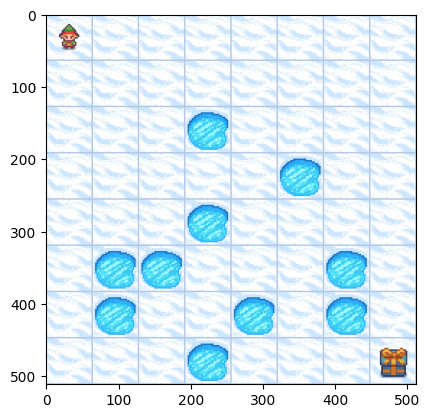

In [4]:
# Run this cell without modification to get a sense of the environment.
tmp_env = gym.make('FrozenLake8x8-v1', render_mode="rgb_array")
tmp_env.reset()
_ = plt.imshow(tmp_env.render())

### Section 1.2: Play the environment with random actions

You need to know 

1. How to step the environment;
2. How to rollout a complete episode.

In [5]:
# Solve the TODOs and remove `pass`

# Run 1000 steps for test, terminate if done.
# You can run this cell multiples times.
env.reset(seed=0)
max_steps = 1000
step = 0
while step < max_steps:
    # Take random action
    # TODO: Uncomment next two lines
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())
    done = terminated or truncated

    # Render the environment.
    # You will see the visualization of the behaviors of the agent
    # if you are using local machine to run this notebook.
    print(env.render())

    print("Current observation: {}\nCurrent reward: {}\n"
          "Whether we are done: {}\ninfo: {}".format(
        observation, reward, done, info
    ))

    wait(sleep=0.1)

    # TODO: Terminate the loop if done
    if done:
        break


  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

Current observation: 19
Current reward: 0.0
Whether we are done: True
info: {'prob': 0.3333333333333333}


### Section 1.3: Define the evaluation function to value the random baseline

Now we need to define an evaluation function to evaluate a given policy.

As a reminder, you should create a `FrozenLake8x8-v1` environment instance by default, reset it after each episode (and at the beginning), step the environment, and terminate the episode if done. According to Gym v26 update, 

After implementing the `evaluate` function, run the next cell to check whether the function is working.

In [6]:
# Solve the TODOs and remove `pass`

def _render_helper(env):
    print(env.render())
    wait(sleep=0.05)


def evaluate(
    policy: Callable,
    num_episodes: int,
    seed: int = 0,
    env_name: str = 'FrozenLake8x8-v1',
    render: bool = False,
    render_mode: str = 'ansi',
) -> float:
    """This function evaluates the given policy and returns the 
    average episodic return across #num_episodes episodes.
    We use `seed` argument for testing purpose.
    You should pass the tests in the next cell.

    :param policy: a function whose input is an integer (observation)
    :param num_episodes: number of episodes you wish to run
    :param seed: an integer, used for testing.
    :param env_name: the name of the environment
    :param render: a boolean flag. If true, please call _render_helper
    function.
    :param render_mode: a string specifies the render mode if render=True.
    :return: the averaged episode reward of the given policy.
    """

    # Create environment (according to env_name, we will use env other than 'FrozenLake8x8-v1')
    env = gym.make(env_name, render_mode=render_mode if render else None)

    # Build inner loop to run.
    # For each episode, do not set the limit.
    # Only terminate episode (reset environment) when done = True.
    # The episode reward is the sum of all rewards happen within one episode.
    # Call the helper function `render(env)` to render
    rewards = []
    for i in range(num_episodes):
        # reset the environment
        obs, info = env.reset(seed=seed + i)
        action = policy(obs)

        ep_reward = 0

        while True:
            # TODO: run the environment and terminate it if done, collect the
            # reward at each step and sum them to the episode reward.

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ep_reward = ep_reward + reward
            action = policy(obs)
           
            if render:
                _render_helper(env)
            if done:
                break
        #break
        rewards.append(ep_reward)
    #print(np.sum(rewards))

    return float(np.mean(rewards))

# TODO: Run next cell to test your implementation!

In [7]:
# Run this cell without modification

# Run this cell to test the correctness of your implementation of `evaluate`.
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3


def expert(obs):
    """Go down if agent at the right edge, otherwise go right."""
    return DOWN if (obs + 1) % 8 == 0 else RIGHT


def assert_equal(seed, value, env_name):
    ret = evaluate(expert, 1000, seed, env_name=env_name)
    assert ret == value, \
        "When evaluate on seed {}~{} in {} environment, the " \
        "averaged reward should be {}. But you get {}." \
        "".format(seed, seed + 1000, env_name, value, ret)


assert_equal(0, 0.046, 'FrozenLake8x8-v1')
assert_equal(1000, 0.047, 'FrozenLake8x8-v1')
assert_equal(2000, 0.065, 'FrozenLake8x8-v1')

assert_equal(0, 0.024, 'FrozenLake-v1')
assert_equal(1000, 0.034, 'FrozenLake-v1')
assert_equal(2000, 0.035, 'FrozenLake-v1')

print("Test Passed!")
print("\nAs a baseline, the mean episode reward of a hand-craft "
      "agent is: ", evaluate(expert, 1000))

Test Passed!

As a baseline, the mean episode reward of a hand-craft agent is:  0.046


Congratulation! You have finished section 1 (if and only if not error happens above).

------

## Section 2: Model-based Tabular RL

(65/100 points)

We have learned how to use the Gym environment to run an episode, as well as how to interact between the agent (policy) and environment via `env.step(action)` to collect observation, reward, done, and possible extra information.

Now we need to build the basic tabular RL algorithm to solve this environment. **Note that compared to the model-free methods in the Sec.3, the algorithms in this section needs to access the internal information of the environment, namely the transition dynamics**. 

In our case, given a state and an action, we need to know which state current environment will jump to, the probability of this transition, and the reward of the transition. You will find that we provide you a helper function `self._get_transitions(state, action)` that takes state and action as input and return you a list of possible transitions.

First, we will implement an abstract class to represent a Trainer. Though this seems to be over-complex for tabular RL, we will use the same framework in the future assignments. So it would be helpful for you to get familiar with how to implement an RL algorithm in the class-oriented programming style.

In [8]:
# Run this cell without modification

class TabularRLTrainerAbstract:
    """This is an abstract class for tabular RL trainer. We will subclass this class
     to implement specific algorithm, so that we can reuse the codes like
    getting the dynamic of the environment (self._get_transitions()) or rendering the
    learned policy (self.render())."""

    def __init__(self, env_name='FrozenLake8x8-v1', model_based=True):
        self.env_name = env_name
        self.env = gym.make(self.env_name)
        self.action_dim = self.env.action_space.n
        self.obs_dim = self.env.observation_space.n

        self.model_based = model_based

        # Define the policy as function that returns the selected action given a state.
        self.policy = None

        # Define the value table as a numpy array.
        self.value_table = None

    def _get_transitions(self, state: int, act: int) -> List:
        """Query the environment to get the transition probability,
        reward, the next state, and done given a pair of state and action.
        We implement this function for you. But you need to know the 
        return format of this function.
        """
        self._check_env_name()
        assert self.model_based, "You should not use _get_transitions in " \
                                 "model-free algorithm!"

        # call the internal attribute of the environments.
        # `transitions` is a list contain all possible next states and the 
        # probability, reward, and termination indicator corresponding to it
        transitions = self.env.unwrapped.P[state][act]

        # Given a state-action pair, it is possible
        # to have multiple transitions, since the 
        # environment is not deterministic.
        # The return of this function: a list of dicts
        ret = []
        for prob, next_state, reward, done in transitions:
            ret.append({
                "prob": prob,
                "next_state": next_state,
                "reward": reward,
                "done": done
            })
        return ret

    def _check_env_name(self):
        assert self.env_name.startswith('FrozenLake')

    def print_table(self):
        """print beautiful table, only work for FrozenLake8X8-v1 env. We 
        write this function for you."""
        self._check_env_name()
        print_table(self.value_table)

    def train(self):
        """Conduct one iteration of learning."""
        raise NotImplementedError("You need to override the "
                                  "Trainer.train() function.")

    def evaluate(self, seed=1000):
        """Use the function you write to evaluate current policy.
        Return the mean episode reward of 1000 episodes when seed=0."""
        result = evaluate(self.policy, seed=seed, num_episodes=1000, env_name=self.env_name)
        return result

    def render(self, seed=1000):
        """Reuse your evaluate function, render current policy 
        for one episode when seed=0"""
        evaluate(self.policy, seed=seed, num_episodes=1, render=True, env_name=self.env_name)

In [9]:
# Run this cell without modification

# Run trainer._get_transitions and give you a sense of how it works.
test_trainer = TabularRLTrainerAbstract()
transitions = test_trainer._get_transitions(state=0, act=0)
print(f"The return transitions is a {type(transitions)}.\n\n{transitions}")

The return transitions is a <class 'list'>.

[{'prob': 0.3333333333333333, 'next_state': 0, 'reward': 0.0, 'done': False}, {'prob': 0.3333333333333333, 'next_state': 0, 'reward': 0.0, 'done': False}, {'prob': 0.3333333333333333, 'next_state': 8, 'reward': 0.0, 'done': False}]


### Section 2.1: Policy Iteration

Recall the process of policy iteration: 

1. Update the state value function, given all possible transitions at current state of the environment.
2. Find the best policy that earns the highest value under current state value function.
3. If the best policy is identical to the previous one then stop the training. Otherwise, return to step 1.

In step 1, update the state value function by

$v_{k+1} = E_{s'}[r(s, a)+\gamma v_{k}(s')]$

wherein the $a$ is given by current policy, $s'$ is next state, $r$ is the reward, $v_{k}(s')$ is the next state value given by the old (not updated yet) value function.
The expectation is computed among all possible transitions given a state and action pair (As the environment is not deterministic, it's possible to transit to different next states even given the same state-action pair).
Note that the new value $v_{k+1}$ should be temporarily stored at some places, instead of

In step 2, the best policy is the one that takes the action with maximal expected return given a state:

$a = {argmax}_a E_{s'}[r(s, a) + \gamma v_{k}(s')]$

Policy iteration algorithm has an outer loop (update policy, step 1 to 3) and an inner loop (fit the value function, within step 1). 

In each outer loop, we call once `trainer.train()`, where we call `trainer.update_value_function()` once to update the value function (the state value table). 

After that we call `trainer.update_policy()` to update the current policy. 

`trainer` object has a `trainer.policy` attribute, which is a function that takes observation as input and returns an action.

You should implement the trainer following the framework we already wrote for you. Please carefully go through the codes and finish all `TODO` in it.

In [10]:
# Solve the TODOs and remove `pass`

class PolicyIterationTrainer(TabularRLTrainerAbstract):
    def __init__(self, gamma=1.0, eps=1e-10, env_name='FrozenLake8x8-v1'):
        super(PolicyIterationTrainer, self).__init__(env_name)

        # Discount factor
        self.gamma = gamma

        # Value function convergence criterion
        self.eps = eps

        # The **value table** for each possible observation
        self.value_table: np.ndarray = np.zeros((self.obs_dim,))

        # TODO: you need to implement a uniform random policy at the beginning.
        # self.policy is a python function that takes an integer (the observation)
        # as input and return an integer (action).
        # You can use self.action_dim to get the dimension (range)
        # of the action. An action is an integer in range
        # [0, ..., self.action_dim - 1]
        # Note: policy should be a deterministic function. That is, given a state,
        # it should always return the same action.
        self.policy: Callable = lambda obs: obs % self.action_dim

        # test your random policy
        test_random_policy(self.policy, self.env)

    def train(self):
        """Conduct one iteration of learning."""
        # TODO: self.value_table may be need to be reset to zeros.
        # If you think it should, than do it. If not, then go ahead.
        # self.value_table = np.zeros((self.obs_dim,))
        self.update_value_function()
        self.update_policy()

    def update_value_function(self):
        count = 0  # count the steps of value updates
        while True:
            old_table = self.value_table.copy()

            for state in range(self.obs_dim):
                action = self.policy(state)
                transition_list = self._get_transitions(state, action)

                state_value = 0
                # Iterate over all possible next states given a state-action pair.
                for transition in transition_list:
                    prob = transition['prob']
                    reward = transition['reward']
                    next_state = transition['next_state']
                    done = transition['done']

                    # TODO: compute state_value
                    # hint: you should use reward, self.gamma, old_table, prob,
                    # and next_state to compute the state value
                    state_value += prob * (reward + self.gamma * old_table[next_state])

                # update the state value
                self.value_table[state] = state_value

            # TODO: Compare the old_table and current table to
            #  decide whether to break the value update process.
            # hint: you should use self.eps, old_table and self.value_table
            should_break: bool =  np.sum(np.abs(old_table - self.value_table)) < self.eps


            if should_break:
                print("[DEBUG]\tThe value table was updated for {} steps. "
                      "Difference between new and old table is: {:.4f}".format(
                    count, np.sum(np.abs(old_table - self.value_table))
                ))
                break
            count += 1
            if count > 6000:
                raise ValueError("Clearly your code has problem. Check it!")

    def update_policy(self):
        """You need to define a new policy function, given current
        value function. The best action for a given state is the one that
        has the highest expected return.

        To optimize computing efficiency, we introduce a policy table,
        which is a numpy array taking state as index and return the action given a state.
        """
        policy_table: np.ndarray = np.zeros([self.obs_dim, ], dtype=int)

        for state in range(self.obs_dim):
            state_action_values = [0] * self.action_dim

            # TODO: assign the action with greatest state-action value
            # to policy_table[state].
            # Hint:
            #  You should use the value table, gamma, reward, as well as 
            #  the return from self._get_transitions() to compute the
            #  state-action value first before getting the action.
            #  Bellman equation may help.
            for action in range(self.action_dim):
                transition_list = self._get_transitions(state, action)
                for transition in transition_list:
                    prob = transition['prob']
                    reward = transition['reward']
                    next_state = transition['next_state']
                    done = transition['done']
                    state_action_values[action] += prob * (reward + self.gamma * self.value_table[next_state])

            best_action = max(range(self.action_dim), key=lambda action : state_action_values[action])

            policy_table[state] = best_action

        self.policy = lambda obs: policy_table[obs]


Now we have built the Trainer class for policy iteration algorithm. In the following few cells, we will train the agent to solve the problem and evaluate its performance.

In [11]:
# Solve the TODOs and remove `pass`

# Managing configurations of your experiments is important for your research.
default_pi_config = dict(
    max_iteration=1000,
    evaluate_interval=1,
    gamma=1.0,
    eps=1e-10
)


def policy_iteration(train_config=None):
    
    # Prepare a config dict
    config = default_pi_config.copy()
    if train_config is not None:
        config.update(train_config)

    # Initialize the trainer
    trainer = PolicyIterationTrainer(gamma=config['gamma'], eps=config['eps'])

    # Initialize an array as the policy mapping obs to action.
    old_policy = np.zeros(trainer.obs_dim, dtype=int)
    old_policy.fill(-1)

    for i in range(config['max_iteration']):

        # train the agent
        trainer.train()

        # TODO: compare the new policy with old policy to check whether
        #  we should stop. If new and old policy have same output given any
        #  observation, then we consider the algorithm is converged and
        #  should be stopped.
        new_policy = list(trainer.policy(obs) for obs in range(trainer.obs_dim))
        should_stop: bool = all(new_policy[obs] == old_policy[obs] for obs in range(trainer.obs_dim))

        if should_stop:
            print("We found policy is not changed anymore at "
                  "iteration {}. Current mean episode reward "
                  "is {}. Stop training.".format(i, trainer.evaluate()))
            break
        old_policy = new_policy

        # evaluate the result
        if i % config['evaluate_interval'] == 0:
            print(
                "[INFO]\tAfter {} iterations, current policy has mean episode reward {}."
                "".format(i, trainer.evaluate()))

            if i > 20:
                print("You sure your codes is OK? It shouldn't take so many "
                      "({}) iterations to train a policy iteration "
                      "agent.".format(i))

    assert trainer.evaluate() > 0.8, \
        "We expect to get the mean episode reward greater than 0.8. " \
        "But you get: {}. Please check your codes.".format(trainer.evaluate())

    return trainer


In [12]:
# Run this cell without modification

# It may be confusing to call a trainer agent. But that's what we normally do.
pi_agent = policy_iteration()

[DEBUG]	The value table was updated for 25 steps. Difference between new and old table is: 0.0000
[INFO]	After 0 iterations, current policy has mean episode reward 0.0.
[DEBUG]	The value table was updated for 92 steps. Difference between new and old table is: 0.0000
[INFO]	After 1 iterations, current policy has mean episode reward 0.0.
[DEBUG]	The value table was updated for 1485 steps. Difference between new and old table is: 0.0000
[INFO]	After 2 iterations, current policy has mean episode reward 0.0.
[DEBUG]	The value table was updated for 144 steps. Difference between new and old table is: 0.0000
[INFO]	After 3 iterations, current policy has mean episode reward 0.0.
[DEBUG]	The value table was updated for 152 steps. Difference between new and old table is: 0.0000
[INFO]	After 4 iterations, current policy has mean episode reward 0.574.
[DEBUG]	The value table was updated for 370 steps. Difference between new and old table is: 0.0000
[INFO]	After 5 iterations, current policy has mean

In [14]:
# Run this cell without modification

print("Your policy iteration agent achieve {} mean episode reward. The optimal score "
      "should be > 0.8.".format(pi_agent.evaluate()))

Your policy iteration agent achieve 0.873 mean episode reward. The optimal score should be > 0.8.


In [15]:
# Run this cell without modification

pi_agent.render()

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [16]:
# Run this cell without modification

pi_agent.print_table()

+-----+-----+-----State Value Mapping-----+-----+-----+
|     |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
|-----+-----+-----+-----+-----+-----+-----+-----+-----|
| 0   |1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 1   |1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 2   |1.000|0.978|0.926|0.000|0.857|0.946|0.982|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 3   |1.000|0.935|0.801|0.475|0.624|0.000|0.945|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 4   |1.000|0.826|0.542|0.000|0.539|0.611|0.852|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----

Congratulations! You have successfully implemented the policy iteration trainer (if and only if no error happens at the above cells). 

Here are few further problems for you to investigate:

1. What is the impact of the discount factor gamma?
2. What is the impact of the value function convergence criterion epsilon?

If you are interested in doing more investigation (not limited to these two), feel free to open new cells at the end of this notebook and left a clear trace of your thinking and coding, which leads to extra credit if you do a good job. It's an optional job, and you can ignore it.

Now let's continue our journey!

### Section 2.2: Value Iteration

Recall the idea of value iteration. We update the state value: 

$$v_{k+1}(s) = \max_a E_{s'} [r(s, a) + \gamma v_{k}(s')]$$

wherein the $s'$ is next state, $r$ is the reward, $v_{k}(s')$ is the next state value given by the old (not updated yet) value function. The expectation is computed among all possible transitions (given a state and action pair, it is possible to have many next states, since the environment is not deterministic).

The value iteration algorithm does not require an inner loop. It computes the expected return of all possible actions at a given state and uses the maximum of them as the state value. You can imagine it "pretends" we already have the optimal policy and run policy iteration based on it. Therefore, we do not need to maintain a policy object in a trainer. We only need to retrieve the optimal policy using the same rule as policy iteration, given current value function.

You should implement the trainer following the framework we already wrote for you. Please carefully go through the code and finish all `TODO` in it.

In [17]:
# Solve the TODOs and remove `pass`


class ValueIterationTrainer(PolicyIterationTrainer):
    """Note that we inherit Policy Iteration Trainer, to reuse the
    code of update_policy(). It's same since it get optimal policy from
    current state-value table (self.table).
    """

    def __init__(self, gamma=1.0, env_name='FrozenLake8x8-v1'):
        super(ValueIterationTrainer, self).__init__(gamma, None, env_name)

    def train(self):
        """Conduct one iteration of learning."""
        # TODO: self.value_table may be need to be reset to zeros.
        # If you think it should, than do it. If not, then move on.


        # In value iteration, we do not explicit require a
        # policy instance to run. We update value function
        # directly based on the transitions. Therefore, we
        # don't need to run self.update_policy() in each step.
        self.update_value_function()

    def update_value_function(self):
        old_table = self.value_table.copy()

        for state in range(self.obs_dim):
            state_value = 0

            # TODO: Compute the new state value.
            # Hint: try to compute the state-action value first
            state_action_values = [0] * self.action_dim
            for action in range(self.action_dim):
                transition_list = self._get_transitions(state, action)
                for transition in transition_list:
                    prob = transition['prob']
                    reward = transition['reward']
                    next_state = transition['next_state']
                    done = transition['done']
                    state_action_values[action] += prob * (reward + self.gamma * old_table[next_state])

            best_action = max(range(self.action_dim), key=lambda action : state_action_values[action])
            state_value = state_action_values[best_action]

            self.value_table[state] = state_value

        # Till now the one-step value update is finished.
        # You can see that we do not use an inner loop to update
        # the value function like what we did in the policy iteration.
        # This is because to compute the state value, which is
        # an expectation among all possible action given by a
        # specified policy, we **pretend** we already have the optimal
        # policy (the max operation). Therefore we don't need to
        # compute the state-action values for those actions that will not
        # be selected by the policy.

    def evaluate(self):
        """Since in value iteration we do not maintain a policy function,
        so we need to retrieve it when we need it."""
        self.update_policy()
        return super().evaluate()

    def render(self):
        """Since in value iteration we do not maintain a policy function,
        so we need to retrieve it when we need it."""
        self.update_policy()
        return super().render()


In [18]:
# Solve the TODOs and remove `pass`

# Managing configurations of your experiments is important for your research.
default_vi_config = dict(
    max_iteration=10000,
    evaluate_interval=100,  # don't need to update policy each iteration
    gamma=1.0,
    eps=1e-10
)


def value_iteration(train_config=None):
    config = default_vi_config.copy()
    if train_config is not None:
        config.update(train_config)

    # [TODO] initialize Value Iteration Trainer. Remember to pass
    #  config['gamma'] to it.
    trainer: TabularRLTrainerAbstract = ValueIterationTrainer(gamma=config['gamma'])

    old_state_value_table = trainer.value_table.copy()

    for i in range(config['max_iteration']):
        # train the agent
        trainer.train()
        old_policy = trainer.policy
        # evaluate the result
        if i % config['evaluate_interval'] == 0:
            print("[INFO]\tIn {} iteration, current "
                  "mean episode reward is {}.".format(
                i, trainer.evaluate()
            ))

            # TODO: Compare the new policy with old policy to check should
            #  we stop.
            # Hint: If new and old policy have same output given any
            #  observation, them we consider the algorithm is converged and
            #  should be stopped.
            should_stop: bool = all(trainer.policy(obs) == old_policy(obs) for obs in range(trainer.obs_dim))


            if should_stop:
                print("We found policy is not changed anymore at "
                      "iteration {}. Current mean episode reward "
                      "is {}. Stop training.".format(i, trainer.evaluate()))
                break

            if i > 3000:
                print("You sure your codes is OK? It shouldn't take so many "
                      "({}) iterations to train a policy iteration "
                      "agent.".format(
                    i))

    assert trainer.evaluate() > 0.8, \
        "We expect to get the mean episode reward greater than 0.8. " \
        "But you get: {}. Please check your codes.".format(trainer.evaluate())

    return trainer


In [19]:
# Run this cell without modification

vi_agent = value_iteration()

[INFO]	In 0 iteration, current mean episode reward is 0.0.
[INFO]	In 100 iteration, current mean episode reward is 0.89.
[INFO]	In 200 iteration, current mean episode reward is 0.882.
[INFO]	In 300 iteration, current mean episode reward is 0.882.
[INFO]	In 400 iteration, current mean episode reward is 0.882.
[INFO]	In 500 iteration, current mean episode reward is 0.882.
We found policy is not changed anymore at iteration 500. Current mean episode reward is 0.882. Stop training.


In [20]:
# Run this cell without modification

print("Your value iteration agent achieve {} mean episode reward. The optimal score "
      "should be > 0.8.".format(vi_agent.evaluate()))

Your value iteration agent achieve 0.882 mean episode reward. The optimal score should be > 0.8.


In [21]:
# Run this cell without modification

vi_agent.render()

  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [22]:
# Run this cell without modification

vi_agent.print_table()

+-----+-----+-----State Value Mapping-----+-----+-----+
|     |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
|-----+-----+-----+-----+-----+-----+-----+-----+-----|
| 0   |0.999|0.999|0.999|0.999|0.999|0.999|0.999|0.999|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 1   |0.999|0.999|0.999|0.999|0.999|0.999|0.999|0.999|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 2   |0.998|0.976|0.925|0.000|0.856|0.945|0.981|0.999|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 3   |0.997|0.932|0.799|0.474|0.623|0.000|0.944|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 4   |0.997|0.823|0.541|0.000|0.539|0.611|0.851|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----

Congratulation! You have successfully implemented the value iteration trainer (if and only if no error happens at the above cells). Few further problems for you to investigate:

1. Do you see that some iteration during training yields better rewards than the final one?  Why does that happen?
2. What is the impact of the discount factor gamma?
3. What is the impact of the value function convergence criterion epsilon?

If you are interested in doing more investigation (not limited to these two), feel free to open new cells at the end of this notebook and left a clear trace of your thinking and coding, which leads to extra credit if you do a good job. It's an optional job, and you can ignore it.

Now let's continue our journey!

### Section 2.3: Compare two model-based agents

Now we have two agents: `pi_agent` and `vi_agent`. They are believed to be the optimal policies in this environment. 

In [23]:
# Run this cell without modification

# Print the value tables of these two policies and see if they match each other.
pi_policy = {obs: pi_agent.policy(obs) for obs in range(pi_agent.obs_dim)}
vi_policy = {obs: vi_agent.policy(obs) for obs in range(vi_agent.obs_dim)}
print("Policy Iteration Agent Policy:\n")
pi_agent.print_table()
print("\nValue Iteration Agent Policy:\n")
vi_agent.print_table()
print("\nState value differences:\n")
print_table((pi_agent.value_table - vi_agent.value_table))

Policy Iteration Agent Policy:

+-----+-----+-----State Value Mapping-----+-----+-----+
|     |   0 |   1 |   2 |   3 |   4 |   5 |   6 |   7 |
|-----+-----+-----+-----+-----+-----+-----+-----+-----|
| 0   |1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 1   |1.000|1.000|1.000|1.000|1.000|1.000|1.000|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 2   |1.000|0.978|0.926|0.000|0.857|0.946|0.982|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 3   |1.000|0.935|0.801|0.475|0.624|0.000|0.945|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| 4   |1.000|0.826|0.542|0.000|0.539|0.611|0.852|1.000|
|     |     |     |     |     |     |     |     |     |
+-----+-----+---

In [ ]:
# You can do more investigation here if you wish. Leave it blank if you don't.


------

## Conclusion and Discussion

In this assignment, we learn how to use the gym (now Gymnasium) library, how to use Object Oriented Programming to build a basic tabular RL algorithm.

Follow the submission instruction in the README to submit your assignment. Thank you!

------

...